# 1. Setup and Import

In [26]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
from tensorflow.keras import layers, models

# 2. Load processed data

In [38]:
data = np.load("../data/preprocessed/stock_dataset.npz", allow_pickle=True)
x_train, y_train = data["x_train"], data["y_train"]
x_val, y_val     = data["x_val"], data["y_val"]
x_test, y_test   = data["x_test"], data["y_test"]
classes          = data["classes"]
num_classes      = len(classes)

print("Train shape:", x_train.shape, y_train.shape)
print("Validation shape:", x_val.shape, y_val.shape)
print("Test shape:", x_test.shape, y_test.shape)
print("Classes:", classes)
print("Number of classes : ", num_classes)

Train shape: (12809, 10, 4) (12809,)
Validation shape: (2744, 10, 4) (2744,)
Test shape: (2746, 10, 4) (2746,)
Classes: ['aadr' 'aaxj' 'acim' 'actx' 'acwf' 'acwi' 'acwv' 'acwx' 'adra' 'adrd']
Number of classes :  10


# 3. Explore the sample

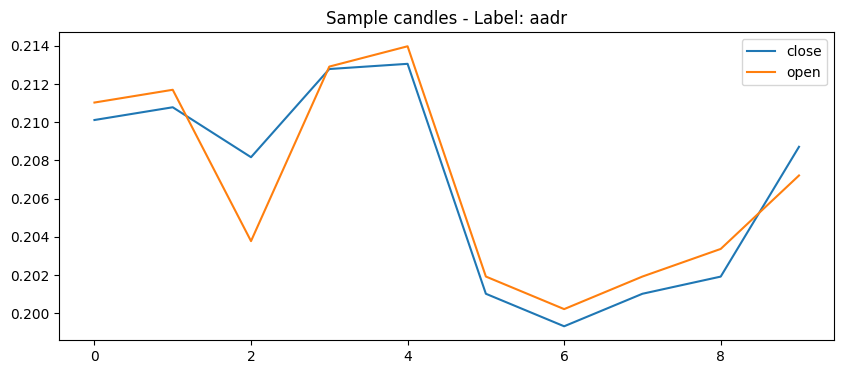

In [39]:
sample = x_train[10]
plt.figure(figsize=(10, 4))
plt.plot(sample[:,3], label="close")
plt.plot(sample[:, 0], label="open")
plt.title(f"Sample candles - Label: {classes[int(y_train[0])]}")
plt.legend()
plt.show()

# 4. Build CNN + LSTM model

In [ ]:
input_shape = x_train.shape[1:]
num_classes = len(classes)

inputs = layers.Input(shape=input_shape)
x = layers.Conv1D(filters=64, kernel_size=3, padding="causal", activation="relu")(inputs)
x = layers.MaxPooling1D(pool_size=2)(x)
x = layers.Conv1D(filters=128, kernel_size=3, padding="causal", activation="relu")(x)
x  = layers.MaxPooling1D(pool_size=2)(x)

x = layers.LSTM(64)(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(64, activation="relu")(x)

outputs = layers.Dense(num_classes, activation="softmax")(x)
model   = models.Model(inputs, outputs)

model.compile(
    optimizer= "adam",
    loss = "sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# 5. Train the Model

In [ ]:
history = model.fit(
    x_train, y_train,
    validation_data = (x_val, y_val),
    epochs=30,
    batch_size=64
)

# 6. Test the model

In [ ]:
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print((f"Test Accuracy : {test_accuracy}"))

# 7. Plot the Training History

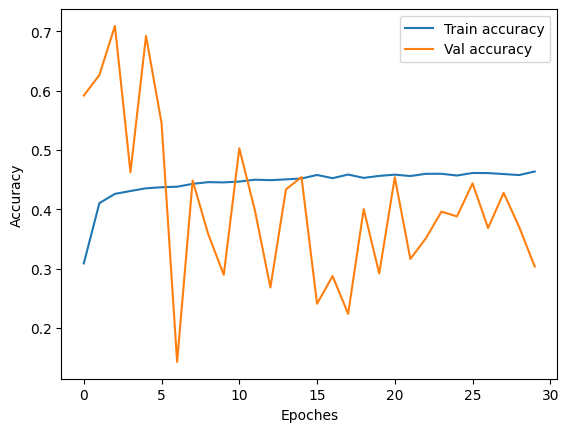

In [43]:
plt.plot(history.history['accuracy'], label= 'Train accuracy')
plt.plot(history.history['val_accuracy'], label = 'Val accuracy')
plt.xlabel('Epoches')
plt.ylabel('Accuracy')
plt.legend()
plt.show()